In [8]:
#league rules!
numberOfTeams = 10

isFlex = True

ppr = 1
rushYards = .1
receivingYards = .1
rushTD = 6
receivingTD = 6
passYards = 1/25
passTD = 4
fmb = -2
int = -2

In [9]:
import pandas as pd, numpy as np
from sklearn.ensemble import RandomForestRegressor
from sklearn.preprocessing import LabelEncoder
import matplotlib.pyplot as plt
from scipy.stats import norm

In [10]:
combo2 = pd.read_csv("2023_model_data.csv")
modelData = combo2.drop(columns=["Name", "Unnamed: 0", "team.y", "position.y", "position.x", "team.x", "nextSeasonsTeam", "gsis_id", "team", "name rank", "gsis_id", "team.y", "position.y"])

In [11]:
#label encoding
label_encoders = {}
for column in modelData.select_dtypes(include=['object']).columns:
    le = LabelEncoder()
    modelData[column] = le.fit_transform(modelData[column])
    label_encoders[column] = le

In [12]:
season = 2023
train = modelData[modelData["year"] < season]
test = modelData[modelData["year"] == season]
c2_whole = combo2[combo2["year"] == season]
names = c2_whole['Name'].reset_index(drop=True)
positions = c2_whole['position'].reset_index(drop=True)

In [13]:
#data
train_y = train["nextSeasonPAR"]
train_x = train.drop(columns = "nextSeasonPAR", axis = 1)
test_y = test["nextSeasonPAR"]
test_x = test.drop(columns = "nextSeasonPAR", axis = 1)

In [14]:
ntrees = 100

In [15]:
#train it
ntrees = 100
rf = RandomForestRegressor(n_estimators=ntrees)
rf.fit(train_x, train_y)

RandomForestRegressor()

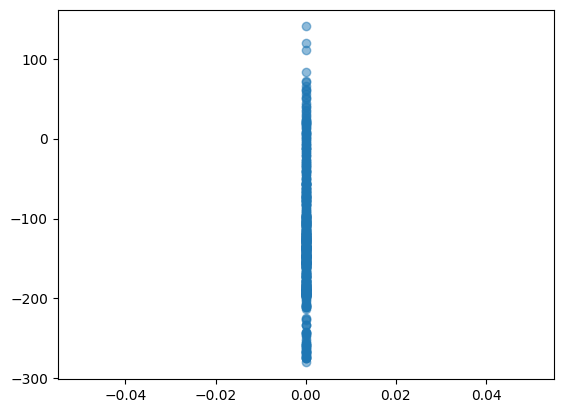

In [16]:
preds = rf.predict(test_x)
plt.scatter(test_y, preds, alpha=.5)

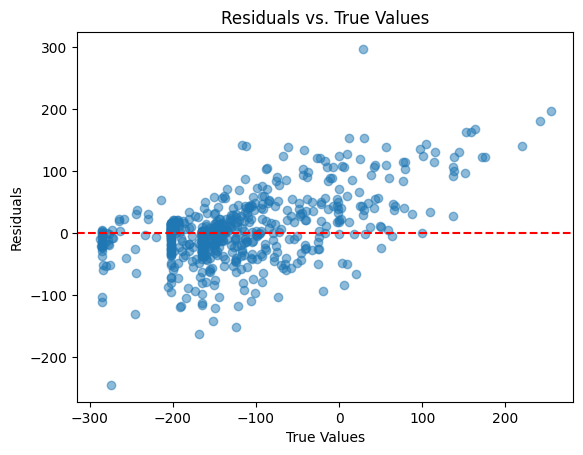

In [53]:
residuals = test_y - preds

# Plot residuals
plt.scatter(test_y, residuals, alpha=0.5)
plt.title('Residuals vs. True Values')
plt.xlabel('True Values')
plt.ylabel('Residuals')
plt.axhline(y=0, color='r', linestyle='--')
plt.show()

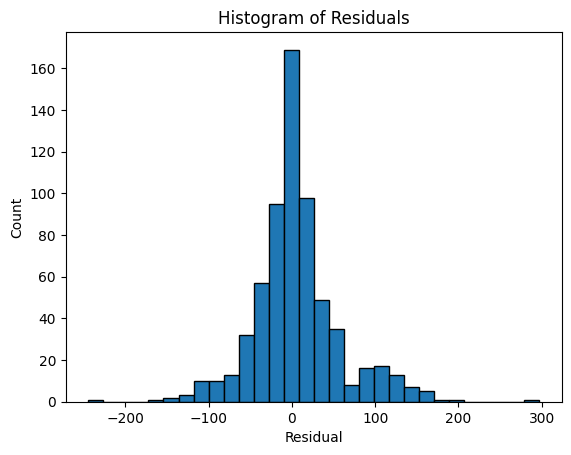

In [54]:
plt.hist(residuals, bins=30, edgecolor='k')
plt.title('Histogram of Residuals')
plt.xlabel('Residual')
plt.ylabel('Count')
plt.show()

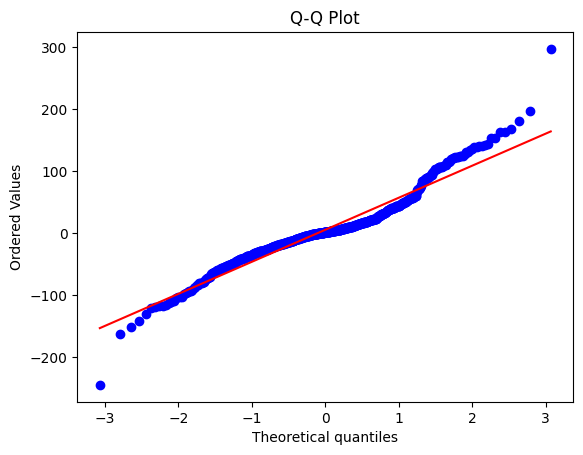

In [55]:
import scipy.stats as stats
stats.probplot(residuals, dist="norm", plot=plt)
plt.title("Q-Q Plot")
plt.show()

In [57]:
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score

mae = mean_absolute_error(test_y, preds)
mse = mean_squared_error(test_y, preds)
r2 = r2_score(test_y, rf.predict(test_x))

print(f"MAE: {mae}, MSE: {mse}, R^2: {r2}")

MAE: 36.10048385093167, MSE: 2858.8496156704346, R^2: 0.6740816888952528


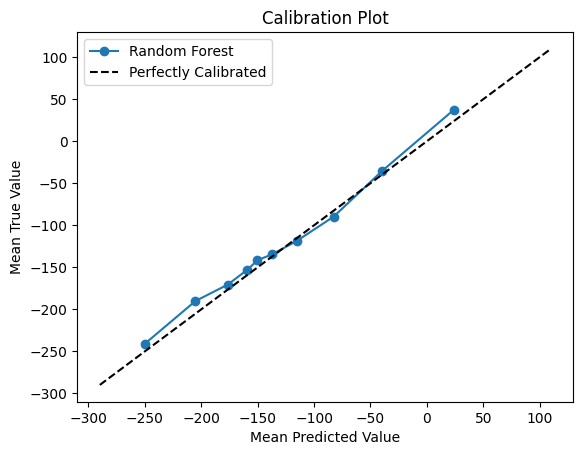

In [58]:
df_calib = pd.DataFrame({'predictions': preds, 'true': test_y})
df_calib['pred_decile'] = pd.qcut(preds, q=10, labels=False)
grouped = df_calib.groupby('pred_decile').mean()

plt.plot(grouped['predictions'], grouped['true'], 'o-', label='Random Forest')
plt.plot([min(preds), max(preds)], [min(preds), max(preds)], 'k--', label='Perfectly Calibrated')
plt.xlabel('Mean Predicted Value')
plt.ylabel('Mean True Value')
plt.title('Calibration Plot')
plt.legend()
plt.show()

In [17]:
#prediction distributions
# Get predictions from each tree in the RandomForestRegressor
tree_predictions = []

for tree in rf.estimators_:
    tree_predictions.append(tree.predict(test_x))

# Convert the predictions to a DataFrame
tree_predictions_df = pd.DataFrame(tree_predictions).transpose()
tree_predictions_df.columns = [f"Tree_{i+1}" for i in range(rf.n_estimators)]

# Display the first few rows of the tree predictions DataFrame
tree_predictions_df.head()

/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X has feature names, but DecisionTreeRegressor was fitted without feature names
  warnings.warn(
/Users/jacksoslow/Documents/Projects/fantasy-football/.venv/lib/python3.9/site-packages/sklearn/base.py:457: UserWarning: X 

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_91,Tree_92,Tree_93,Tree_94,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100
0,-133.30,103.46,30.20,176.94,65.34,109.40,-161.90,2.50,140.60,-114.10,...,153.00,77.56,70.70,10.10,78.70,-91.54,13.00,144.18,78.70,0.00
1,27.22,-30.80,185.32,57.22,27.22,144.18,-164.34,-37.12,-164.34,88.72,...,125.72,198.50,185.32,172.92,125.72,171.40,48.60,144.18,57.22,27.22
2,138.22,88.72,226.40,57.22,0.00,109.40,138.22,13.00,-164.34,88.72,...,65.34,144.18,183.00,-145.06,0.00,171.40,-145.06,197.74,81.42,197.74
3,-74.10,190.24,241.40,109.40,164.00,77.40,62.80,109.40,-71.50,62.80,...,-74.10,-19.00,164.00,83.20,239.86,164.00,-161.90,254.46,5.50,62.80
4,102.00,3.56,-245.58,125.34,13.00,-12.70,-149.04,-21.28,171.26,176.94,...,22.48,-5.50,185.32,3.56,172.92,-150.90,95.36,119.80,102.00,3.56


In [18]:
#include more details in pred dataframe
tree_predictions_df['name'] = names
tree_predictions_df['preds'] = preds
tree_predictions_df['pos'] = positions

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_94,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos
0,-133.30,103.46,30.20,176.94,65.34,109.40,-161.90,2.50,140.60,-114.10,...,10.10,78.70,-91.54,13.00,144.18,78.70,0.00,PatrickMahomes,34.9930,QB
1,27.22,-30.80,185.32,57.22,27.22,144.18,-164.34,-37.12,-164.34,88.72,...,172.92,125.72,171.40,48.60,144.18,57.22,27.22,JalenHurts,52.0410,QB
2,138.22,88.72,226.40,57.22,0.00,109.40,138.22,13.00,-164.34,88.72,...,-145.06,0.00,171.40,-145.06,197.74,81.42,197.74,JoshAllen,29.0834,QB
3,-74.10,190.24,241.40,109.40,164.00,77.40,62.80,109.40,-71.50,62.80,...,83.20,239.86,164.00,-161.90,254.46,5.50,62.80,ChristianMcCaffrey,70.4988,RB
4,102.00,3.56,-245.58,125.34,13.00,-12.70,-149.04,-21.28,171.26,176.94,...,3.56,172.92,-150.90,95.36,119.80,102.00,3.56,JoeBurrow,40.0046,QB
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
606,-147.90,-168.30,-165.40,-166.00,-165.70,-114.10,-168.30,-147.40,-149.30,-168.30,...,-168.30,-142.70,-147.40,-168.30,-149.30,-164.20,-160.80,JakeTonges,-154.4200,TE
607,-202.40,-124.26,-193.00,-124.26,-210.82,-202.40,-210.82,-191.20,-202.40,-202.40,...,-202.40,-202.40,-181.00,-209.64,-216.42,-124.26,-172.24,JoshAli,-183.6828,WR
608,-275.70,-253.48,-275.90,-274.74,-86.40,-275.90,-253.48,-266.64,-264.04,-264.84,...,-270.08,-264.84,-272.78,-273.44,-273.08,-272.02,-273.44,NateSudfeld,-267.6190,QB
609,-276.54,-159.30,-275.90,-266.00,-273.04,-275.90,-224.30,-274.32,-274.74,-275.90,...,-256.14,-276.54,-275.94,-275.90,-274.08,-272.02,-256.14,CJBeathard,-270.9918,QB


In [20]:
#add posrank
# Group by position, sort by RF_Prediction in descending order, then assign a rank within each group
tree_predictions_df['posrank'] = np.int64(tree_predictions_df.groupby('pos')['preds'].rank(ascending=False, method='min'))

# Sort the DataFrame based on position and then by Positional_Rank
tree_predictions_df = tree_predictions_df.sort_values(by=['pos', 'posrank'])

tree_predictions_df

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank
1,27.22,-30.80,185.32,57.22,27.22,144.18,-164.34,-37.12,-164.34,88.72,...,125.72,171.40,48.60,144.18,57.22,27.22,JalenHurts,52.0410,QB,1
4,102.00,3.56,-245.58,125.34,13.00,-12.70,-149.04,-21.28,171.26,176.94,...,172.92,-150.90,95.36,119.80,102.00,3.56,JoeBurrow,40.0046,QB,2
28,-140.66,155.66,61.26,163.68,171.26,61.26,-280.70,-28.70,34.40,6.72,...,172.92,-10.90,155.66,0.00,-57.58,172.92,JustinFields,36.1684,QB,3
0,-133.30,103.46,30.20,176.94,65.34,109.40,-161.90,2.50,140.60,-114.10,...,78.70,-91.54,13.00,144.18,78.70,0.00,PatrickMahomes,34.9930,QB,4
2,138.22,88.72,226.40,57.22,0.00,109.40,138.22,13.00,-164.34,88.72,...,0.00,171.40,-145.06,197.74,81.42,197.74,JoshAllen,29.0834,QB,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
567,-209.64,-202.40,-200.20,-200.20,-200.20,-220.14,-202.40,-220.14,-220.14,-200.20,...,-209.64,-202.40,-220.14,-216.42,-216.42,-200.20,OdellBeckham,-209.6728,WR,232
583,-209.64,-202.40,-216.42,-202.40,-202.40,-220.14,-202.40,-220.14,-220.14,-202.40,...,-209.64,-202.40,-221.36,-216.42,-216.42,-200.20,MarvinMims,-210.2114,WR,233
566,-209.64,-202.40,-200.20,-204.00,-199.10,-220.14,-202.40,-220.14,-220.14,-202.40,...,-209.64,-202.40,-221.36,-216.42,-216.42,-200.20,JordanAddison,-210.5238,WR,234
568,-209.64,-202.40,-200.20,-204.00,-200.20,-220.14,-202.40,-220.14,-220.14,-202.40,...,-209.64,-202.40,-221.36,-216.42,-216.42,-200.20,GabrielDavis,-210.6072,WR,235


In [21]:
#make the "individuals" df
individuals = tree_predictions_df.copy()
tree_predictions_df[tree_predictions_df['posrank'] <= 3]

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_95,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank
1,27.22,-30.80,185.32,57.22,27.22,144.18,-164.34,-37.12,-164.34,88.72,...,125.72,171.40,48.60,144.18,57.22,27.22,JalenHurts,52.0410,QB,1
4,102.00,3.56,-245.58,125.34,13.00,-12.70,-149.04,-21.28,171.26,176.94,...,172.92,-150.90,95.36,119.80,102.00,3.56,JoeBurrow,40.0046,QB,2
28,-140.66,155.66,61.26,163.68,171.26,61.26,-280.70,-28.70,34.40,6.72,...,172.92,-10.90,155.66,0.00,-57.58,172.92,JustinFields,36.1684,QB,3
6,176.20,171.20,137.50,234.60,176.20,174.30,227.80,137.50,120.00,295.20,...,241.40,142.16,212.10,171.20,212.10,-157.30,AustinEkeler,140.2866,RB,1
19,35.10,227.80,37.40,251.70,166.38,171.20,41.20,-150.90,-19.40,62.40,...,32.60,-71.50,125.00,254.46,-114.10,67.10,DerrickHenry,83.8566,RB,2
3,-74.10,190.24,241.40,109.40,164.00,77.40,62.80,109.40,-71.50,62.80,...,239.86,164.00,-161.90,254.46,5.50,62.80,ChristianMcCaffrey,70.4988,RB,3
5,110.10,-119.16,-27.00,6.10,154.10,21.28,9.00,-44.40,74.60,251.70,...,-155.00,-162.00,-74.10,90.72,239.86,91.60,TravisKelce,42.6630,TE,1
33,84.40,-150.90,-79.34,66.60,-76.40,-65.20,117.50,82.70,67.50,22.60,...,20.30,158.90,-121.40,117.50,19.46,67.50,TJHockenson,22.5480,TE,2
50,135.12,-245.58,-59.60,28.00,-12.60,91.60,124.70,41.30,121.40,95.20,...,41.90,-133.30,-121.40,25.60,-21.80,97.80,GeorgeKittle,20.4398,TE,3
7,239.86,166.38,151.40,149.66,147.50,99.60,130.10,184.50,64.44,164.00,...,239.86,-8.24,170.18,131.20,142.16,21.28,JustinJefferson,119.5592,WR,1


In [22]:
#make a pred copy df
preds_copy = test_x.reset_index(drop=True).copy()
preds_copy['name'] = names
preds_copy['pos'] = positions
preds_copy['preds'] = preds
preds_copy['adp'] = preds_copy['rank'] * 1.2
preds_copy['adp_sd'] = preds_copy['rank'] * .5 + 1


preds_copy = preds_copy[['name', 'pos', 'rank', 'PAR', 'preds', 'adp', 'adp_sd']]

preds_copy.sort_values(by = 'rank')

,name,pos,rank,PAR,preds,adp,adp_sd
7,JustinJefferson,WR,1,175.08,119.5592,1.2,1.5
6,AustinEkeler,RB,2,217.30,140.2866,2.4,2.0
20,JaMarrChase,WR,3,99.94,66.3996,3.6,2.5
3,ChristianMcCaffrey,RB,4,251.56,70.4988,4.8,3.0
5,TravisKelce,TE,5,241.40,42.6630,6.0,3.5
...,...,...,...,...,...,...,...
333,ZachGentry,TE,300,-117.10,-137.0010,360.0,151.0
332,DyamiBrown,WR,300,-169.60,-153.7532,360.0,151.0
331,BrevinJordan,TE,300,-116.50,-136.7580,360.0,151.0
329,JalenNailor,WR,300,-169.50,-173.4164,360.0,151.0


In [23]:
#get replacement level player by position
import pandas as pd

# Filtering data based on conditions
replacement_rb = individuals[(individuals['pos'] == 'RB') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_wr = individuals[(individuals['pos'] == 'WR') & (individuals['posrank'] == 26)].iloc[:, :ntrees]
replacement_te = individuals[(individuals['pos'] == 'TE') & (individuals['posrank'] == 11)].iloc[:, :ntrees]
replacement_qb = individuals[(individuals['pos'] == 'QB') & (individuals['posrank'] == 11)].iloc[:, :ntrees]

In [24]:
#roundup function
def roundUp(x, to=numberOfTeams):
    return to * (x // to + (x % to > 0))

In [25]:
#your team
draftedOverall = []

yourTeam = []

In [26]:
def draft_optimize(individuals = individuals, yourTeam = yourTeam, draftedOverall = draftedOverall, preds_copy = preds_copy):
    # Assuming necessary data is already loaded: individuals, preds_copy, draftedOverall, yourTeam, etc.
    # ... [Your data loading code here]

    # Initialize DataFrames and lists
    createdDataframe = pd.DataFrame()
    secondDataframe = pd.DataFrame()
    created_rows = []

    yourDraft = individuals[individuals['name'].isin(yourTeam)]
    yourDraft['teamrank'] = np.int64(yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min'))

    first_rb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'RB')]
    second_rb = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'RB')]
    third_rb = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'RB')]
    first_wr = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'WR')]
    second_wr = yourDraft[(yourDraft['teamrank'] == 2) & (yourDraft['pos'] == 'WR')]
    third_wr = yourDraft[(yourDraft['teamrank'] == 3) & (yourDraft['pos'] == 'WR')]
    first_te = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'TE')]
    first_qb = yourDraft[(yourDraft['teamrank'] == 1) & (yourDraft['pos'] == 'QB')]

    first_flex = third_rb if third_rb.preds.max() > third_wr.preds.max() else third_wr

    # For RBs
    t_rb = replacement_rb.transpose()
    rbs = pd.concat([t_rb.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_rb.empty:
        rbs.iloc[0, :] = first_rb.iloc[0, :500]
    if not second_rb.empty:
        rbs.iloc[1, :] = second_rb.iloc[0, :500]
    if not first_flex.empty:
        rbs.iloc[2, :] = first_flex.iloc[0, :500]

    # For WRs
    t_wr = replacement_wr.transpose()
    wrs = pd.concat([t_wr.sample(frac=1).transpose() for _ in range(3)], axis=0)
    if not first_wr.empty:
        wrs.iloc[0, :] = first_wr.iloc[0, :500]
    if not second_wr.empty:
        wrs.iloc[1, :] = second_wr.iloc[0, :500]
    if not first_flex.empty:
        wrs.iloc[2, :] = first_flex.iloc[0, :500]

    # For TEs
    tes = replacement_te.copy()  # Create a copy to prevent modification of original dataframe
    if not first_te.empty:
        tes.iloc[0, :] = first_te.iloc[0, :500]

    # For QBs
    qbs = replacement_qb.copy()  # Create a copy to prevent modification of original dataframe
    if not first_qb.empty:
        qbs.iloc[0, :] = first_qb.iloc[0, :500]

    # Dictionary for positions
    pos_dict = {
        'RB': rbs,
        'WR': wrs,
        'TE': tes,
        'QB': qbs
    }

    # Filter out players in draftedOverall from copy
    available = preds_copy[~preds_copy['name'].isin(draftedOverall)]
    available = available.sort_values(by=['pos', 'preds'], ascending=False).groupby('pos').head(25).reset_index(drop=True)

    for j in range(len(available)):
        player = available.iloc[j]
        name = player['name']
        position = player['pos']

        # Use dictionary to get positional_df
        positional_df = pos_dict[position]

        indi_preds = individuals[(individuals['name'] == name) & (individuals['pos'] == position)].iloc[:, :ntrees].iloc[0]
        total_pt_gains = 0
        pct_better = 0

        for i in range(len(positional_df)):
            row = positional_df.iloc[i]
            better = indi_preds.values > row[::-1].values  # Using values to get numpy arrays
            pct_better = max(pct_better, sum(better) / ntrees)
            avg_pts_gains = np.mean(indi_preds[better].values - np.array(row[::-1])[better])
            total_pt_gains = max(total_pt_gains, pct_better * avg_pts_gains)

        # Finding pick number, your next pick, and the likelihood of a player staying on board
        pickNumber = len(draftedOverall) + 1
        ceiling = roundUp(pickNumber, numberOfTeams)
        leftTillEndOfRound = ceiling - pickNumber
        nextPick = ceiling + leftTillEndOfRound + 1

        # Calculating the chance of staying on board
        chanceOfStayingOnBoard = round(1 - norm.cdf(nextPick, player['adp'], player['adp_sd']), 2)

        # For the round after the likelihood
        ceiling = roundUp(nextPick, numberOfTeams)
        leftTillEndOfRound = ceiling - nextPick
        pickAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnBoardTwoRounds = 1 - norm.cdf(pickAfter, player['adp'], player['adp_sd'])

        # For the round after...
        ceiling = roundUp(pickAfter, numberOfTeams)
        leftTillEndOfRound = ceiling - pickAfter
        pickEvenAfter = ceiling + leftTillEndOfRound + 1

        chanceOfStayingOnThreeRounds = 1 - norm.cdf(pickEvenAfter, player['adp'], player['adp_sd'])

        # Creating a dictionary to represent the new row
        created_row = {
            'name': player['name'],
            'pos': position,
            'preds': player['preds'],
            'pct_better': pct_better,
            'ADP': player['adp'],
            'total_pt_gains': total_pt_gains,
            'chanceOfStayingOnBoard': chanceOfStayingOnBoard,
            'chanceOfStayingOnBoardTwoRounds': chanceOfStayingOnBoardTwoRounds,
            'chanceOfStayingOnThreeRounds': chanceOfStayingOnThreeRounds
        }
        created_rows.append(created_row)

    # Convert the created rows to a DataFrame
    createdDataframe = pd.DataFrame(created_rows)

    # Process for the second dataframe
    second_rows = []

    for _, newRow in createdDataframe.iterrows():
        playerPosition = newRow['pos']

        # Filter and sort
        positionallyFiltered = createdDataframe[createdDataframe['pos'] == playerPosition]
        positionallyFiltered = positionallyFiltered.sort_values(by='total_pt_gains', ascending=False).head(12).copy()

        # Initialize new columns
        positionallyFiltered['chance_of_best_option'] = 0
        positionallyFiltered['chance_of_best_option_2'] = 0
        positionallyFiltered['chance_of_best_option_3'] = 0

        for j, row in positionallyFiltered.iterrows():
            better_players = positionallyFiltered[positionallyFiltered['total_pt_gains'] > row['total_pt_gains']]

            # Calculating probabilities for best option next round
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoard'])
            p_avail = row['chanceOfStayingOnBoard']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option'] = p_best_option

            # ... for two rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnBoardTwoRounds'])
            p_avail = row['chanceOfStayingOnBoardTwoRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_2'] = p_best_option

            # ... and for three rounds later
            p_noone_better = np.prod(1 - better_players['chanceOfStayingOnThreeRounds'])
            p_avail = row['chanceOfStayingOnThreeRounds']
            p_best_option = p_noone_better * p_avail
            positionallyFiltered.at[j, 'chance_of_best_option_3'] = p_best_option

        # Calculating average positional values
        nextRoundValue = np.sum(positionallyFiltered['chance_of_best_option'] * positionallyFiltered['total_pt_gains'])
        nextRoundValue = 1000 if np.isinf(nextRoundValue) or np.isnan(nextRoundValue) else nextRoundValue
        newRow['valueOverNextRound'] = newRow['total_pt_gains'] - nextRoundValue

        valueOverTwoRounds = np.sum(positionallyFiltered['chance_of_best_option_2'] * positionallyFiltered['total_pt_gains'])
        valueOverTwoRounds = 1000 if np.isinf(valueOverTwoRounds) or np.isnan(valueOverTwoRounds) else valueOverTwoRounds
        newRow['valueOverTwoRounds'] = newRow['total_pt_gains'] - valueOverTwoRounds

        valueOverThreeRounds = np.sum(positionallyFiltered['chance_of_best_option_3'] * positionallyFiltered['total_pt_gains'])
        valueOverThreeRounds = 1000 if np.isinf(valueOverThreeRounds) or np.isnan(valueOverThreeRounds) else valueOverThreeRounds
        newRow['valueOverThreeRounds'] = newRow['total_pt_gains'] - valueOverThreeRounds

        second_rows.append(newRow)

    secondDataframe = pd.DataFrame(second_rows)
    return secondDataframe

In [29]:
secondDataframe = draft_optimize()
desired_columns = ['name', 'pos', 'valueOverNextRound', 'ADP', 'chanceOfStayingOnBoard', 'preds']
secondDataframe = pd.concat([secondDataframe[desired_columns], secondDataframe.drop(desired_columns, axis=1)], axis=1)

secondDataframe.sort_values(by = 'valueOverNextRound', ascending = False)

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
50,AustinEkeler,RB,70.685136,2.4,0.00,140.2866,0.85,178.2892,0.000000,0.000000,72.093981,102.754961
0,JustinJefferson,WR,31.706521,1.2,0.00,119.5592,0.91,139.2414,0.000000,0.000000,34.283288,81.747534
51,DerrickHenry,RB,23.081136,12.0,0.09,83.8566,0.77,130.6852,0.066807,0.000002,24.489981,55.150961
1,CeeDeeLamb,WR,23.067321,16.8,0.34,111.4798,0.92,130.6022,0.299792,0.001866,25.644088,73.108334
25,TravisKelce,TE,21.831956,6.0,0.00,42.6630,0.73,101.3356,0.000009,0.000000,21.917649,23.503991
...,...,...,...,...,...,...,...,...,...,...,...,...
98,JordanLove,QB,-81.589311,294.0,0.99,-136.0058,0.26,25.5974,0.986466,0.980141,-81.558574,-80.421216
96,AnthonyRichardson,QB,-81.687311,140.4,0.98,-118.1908,0.30,25.4994,0.977610,0.954236,-81.656574,-80.519216
94,DerekCarr,QB,-82.436111,262.8,0.99,-109.8474,0.31,24.7506,0.985674,0.978115,-82.405374,-81.268016
97,CJStroud,QB,-82.479711,320.4,0.99,-124.5558,0.26,24.7070,0.986994,0.981454,-82.448974,-81.311616


In [32]:
with pd.option_context('display.max_rows', None, 'display.max_columns', None): 
    display(secondDataframe.sort_values(by = 'preds', ascending = False))

,name,pos,valueOverNextRound,ADP,chanceOfStayingOnBoard,preds,pct_better,total_pt_gains,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverTwoRounds,valueOverThreeRounds
50,AustinEkeler,RB,70.685136,2.4,0.00,140.2866,0.85,178.2892,0.000000e+00,0.000000e+00,72.093981,102.754961
0,JustinJefferson,WR,31.706521,1.2,0.00,119.5592,0.91,139.2414,0.000000e+00,0.000000e+00,34.283288,81.747534
1,CeeDeeLamb,WR,23.067321,16.8,0.34,111.4798,0.92,130.6022,2.997916e-01,1.865813e-03,25.644088,73.108334
51,DerrickHenry,RB,23.081136,12.0,0.09,83.8566,0.77,130.6852,6.680720e-02,1.530627e-06,24.489981,55.150961
2,AJBrown,WR,-1.481279,20.4,0.52,71.9400,0.77,106.0536,4.748204e-01,1.954881e-02,1.095488,48.559734
52,ChristianMcCaffrey,RB,13.913536,4.8,0.00,70.4988,0.69,121.5176,3.332045e-08,0.000000e+00,15.322381,45.983361
3,JaMarrChase,WR,-4.180279,3.6,0.00,66.3996,0.70,103.3546,1.701417e-12,0.000000e+00,-1.603512,45.860734
53,JonathanTaylor,RB,1.307336,14.4,0.21,62.0468,0.70,108.9114,1.728770e-01,1.275211e-04,2.716181,33.377161
54,TonyPollard,RB,1.825336,24.0,0.64,60.5184,0.79,109.4294,6.074686e-01,7.289757e-02,3.234181,33.895161
4,DavanteAdams,WR,-11.663479,13.2,0.15,59.6212,0.72,95.8714,1.150697e-01,1.869224e-05,-9.086712,38.377534


In [34]:
draft_optimize()

,name,pos,preds,pct_better,ADP,total_pt_gains,chanceOfStayingOnBoard,chanceOfStayingOnBoardTwoRounds,chanceOfStayingOnThreeRounds,valueOverNextRound,valueOverTwoRounds,valueOverThreeRounds
0,JustinJefferson,WR,119.5592,0.87,1.2,143.7710,0.00,0.000000e+00,0.000000,36.680057,39.488931,109.542010
1,CeeDeeLamb,WR,111.4798,0.89,16.8,133.9694,0.34,2.997916e-01,0.001866,26.878457,29.687331,99.740410
2,AJBrown,WR,71.9400,0.80,20.4,101.3710,0.52,4.748204e-01,0.019549,-5.719943,-2.911069,67.142010
3,JaMarrChase,WR,66.3996,0.72,3.6,102.5502,0.00,1.701417e-12,0.000000,-4.540743,-1.731869,68.321210
4,DavanteAdams,WR,59.6212,0.77,13.2,97.3902,0.15,1.150697e-01,0.000019,-9.700743,-6.891869,63.161210
...,...,...,...,...,...,...,...,...,...,...,...,...
95,KylerMurray,QB,-113.8756,0.27,207.6,36.8894,0.98,9.835201e-01,0.972281,-70.297311,-70.266574,-69.129216
96,AnthonyRichardson,QB,-118.1908,0.30,140.4,25.4994,0.98,9.776104e-01,0.954236,-81.687311,-81.656574,-80.519216
97,CJStroud,QB,-124.5558,0.26,320.4,24.7070,0.99,9.869937e-01,0.981454,-82.479711,-82.448974,-81.311616
98,JordanLove,QB,-136.0058,0.26,294.0,25.5974,0.99,9.864657e-01,0.980141,-81.589311,-81.558574,-80.421216


In [131]:
print(yourDraft['preds'].isnull().sum())


0


In [132]:
print(pd.__version__)


2.0.3


In [137]:
yourDraft.groupby('pos')['preds'].rank(ascending=False, method='min').apply(lambda x: np.int64(x).item())

9    1
Name: preds, dtype: int64

In [138]:
yourDraft

,Tree_1,Tree_2,Tree_3,Tree_4,Tree_5,Tree_6,Tree_7,Tree_8,Tree_9,Tree_10,...,Tree_96,Tree_97,Tree_98,Tree_99,Tree_100,name,preds,pos,posrank,ranked_preds
9,41.2,120.0,67.1,125.0,58.8,-141.2,62.8,7.6,295.2,62.8,...,106.06,251.7,137.5,24.0,150.8,JonathanTaylor,73.8214,RB,4,1
